<a href="https://colab.research.google.com/github/Zokoban/pyOCRTEN/blob/Full_TensorFlow/ocr_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download all data on the drive 

In [9]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

replace IAM_Words/words.tgz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
y
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/words’: File exists


## Load all the required packages

In [10]:
import pandas as pd
import numpy as np
import csv
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## Load word.txt file

In [11]:
word_txt=pd.read_csv("data/words.txt", 
                     sep=' ', 
                     names=["word_id","segmentation_result","gray_level","x","y","pxw","pxh","grammatical_tag","transcription_1","transcription_2","transcription_3"], 
                     quoting=csv.QUOTE_NONE, 
                     skiprows=18, 
                     on_bad_lines="warn")

def f(x):
    if x == "nan":
        return ""
    else:
        return x
word_txt["transcription"]=word_txt.transcription_1.astype("str")+word_txt.transcription_2.astype("str").apply(f)+word_txt.transcription_3.astype("str").apply(f)
word_txt=word_txt.drop(columns=["transcription_1","transcription_2","transcription_3"])

def f(x):
    return len(x)

word_txt["number_components"]=word_txt.transcription.apply(f)

print("word_txt Length: ",len(word_txt))
word_txt.head()

word_txt Length:  115320


,word_id,segmentation_result,gray_level,x,y,pxw,pxh,grammatical_tag,transcription,number_components
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,1
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,4
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,2
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,4
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,3


### Choice of the fraction of the dataset.
### Removal of the transcription error.
### Removal of the unwanted columns.

In [12]:
#############
# Variables #
#############

fraction = 0.5
data_dir = "data/words/"
image_extensions = [".png"]  # add there all your images file extensions
img_type_accepted_by_tf = ["png"]

#--------------------------------------------------------------------------
from pathlib import Path
import imghdr

def img_path(word):
    path=data_dir+word.split("-")[0]+"/"+word.split("-")[0]+"-"+word.split("-")[1]+"/"+word+".png"
    
    return path

def removal_of_corrupt_image(df):
  index_to_drop=[]
  for filepath in Path(data_dir).rglob("*"):
      if filepath.suffix.lower() in image_extensions:
          img_type = imghdr.what(filepath)
          if img_type is None:
              index_to_drop.append(df[df.filepath==str(filepath)].index)
              df=df.drop(labels=df[df.filepath==str(filepath)].index)
              print(f"{filepath} is not an image")
          elif img_type not in img_type_accepted_by_tf:
              df=df.drop(labels=df[df.filepath==str(filepath)].index)
              print(f"{filepath} is a {img_type}, not accepted by TensorFlow and is drop")
  return df

##################################
#   Removal of unwanted Column   #
##################################

list_columns_to_remove=["segmentation_result","gray_level","x","y","pxw","pxh","grammatical_tag","number_components"]

df = word_txt[word_txt.segmentation_result == "ok"]\
    .drop(columns=list_columns_to_remove)\
    .sample(frac=fraction,random_state=1234)

#----------------------------------------------------

###############################
#    Removal of corrupt image #
###############################

print("df Length: ",len(df))
df["filepath"]=df.word_id.apply(img_path)
df=removal_of_corrupt_image(df)
print("df Length: ",len(df))
df.head()

df Length:  48228
data/words/a01/a01-117/a01-117-05-02.png is not an image
data/words/r06/r06-022/r06-022-03-05.png is not an image
df Length:  48227


,word_id,transcription,filepath
23187,c02-022-03-01,indignity,data/words/c02/c02-022/c02-022-03-01.png
38064,d06-107-08-01,with,data/words/d06/d06-107/d06-107-08-01.png
20965,b06-023-03-03,an,data/words/b06/b06-023/b06-023-03-03.png
77141,h07-063b-00-00,More,data/words/h07/h07-063b/h07-063b-00-00.png
56002,g04-063-03-05,volunteer,data/words/g04/g04-063/g04-063-03-05.png


## Separation of dataset and Loading + Preprocessing of the image

###Loading and preprocessing functions

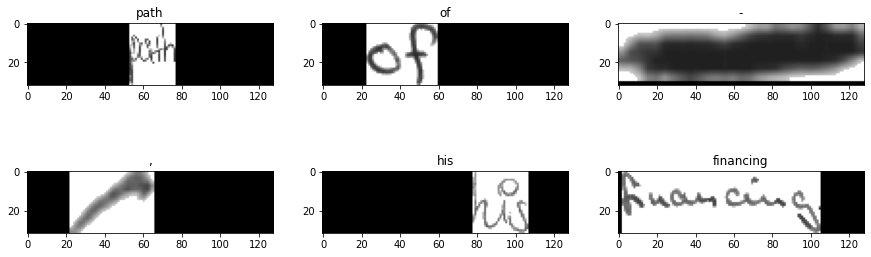

In [13]:
#############
# Variables #
#############

batch_size = 128
image_width=128
image_height=32
imgSize = (image_height, image_width)

#-----------------------------------

###############################################################
# Definition of functions:                                    #
#     - Loading images                                        #
#     - Preprocessing of images (resizing without distortion) #
###############################################################

import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

#Loading function of images (with tensorflow)
@tf.function
def load_image(filepath):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=0)

    return im

#Preprocessing function of images (with tensorflow)
@tf.function
def preprocess(filepath, imgSize=(32, 128), dataAugmentation=False, scale=0.8, isthreshold=False):



    img = load_image(filepath)/255
    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = tf.ones([imgSize[0], imgSize[1], 1])
        print("None")

    if dataAugmentation:
        stretch = scale*(tf.random.uniform([1], 0, 1)[0] - 0.3) # -0.5 .. +0.5
        wStretched = tf.maximum(int(float(tf.shape(img)[0]) * (1 + stretch)), 1) # random width, but at least 1
        img = tf.image.resize(img, (wStretched, tf.shape(img)[1])) # stretch horizontally by factor 0.5 .. 1.5

    (wt, ht) = imgSize

    w, h = float(tf.shape(img)[0]), float(tf.shape(img)[1])

    fx = w / wt
    fy = h / ht

    f = tf.maximum(fx, fy)

    newSize = (tf.maximum(tf.minimum(wt, int(w / f)), 1), tf.maximum(tf.minimum(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)

    img = tf.image.resize(img, newSize)


    dx = wt - newSize[0]
    dy = ht - newSize[1]

    if dataAugmentation :
        dx1=0
        dy1=0
        if dx!=0:
            dx1 = tf.random.uniform([1], 0, dx, tf.int32)[0]
        if dy!=0:
            dy1 = tf.random.uniform([1], 0, dy, tf.int32)[0]
        img = tf.pad(img[..., 0], [[dx1, dx-dx1], [dy1, dy-dy1]], constant_values=0)
    else :
        img = tf.pad(img[..., 0], [[0, dx], [0, dy]], constant_values=0)

    if isthreshold:
        return tf.expand_dims(1-(1-img)*tf.cast(img < 0.8, tf.float32), -1)
    return tf.expand_dims(img, -1)

#-----------------------------------------------------------------------------

#########################################
# Creation of the train & test datasets #
#########################################

#Split of dataframes 
X_train_path, X_test_path, y_train, y_test = train_test_split(df.filepath.values, df.transcription.values, train_size=0.9, random_state=1234)

# Creation of dataset_train tensor and preprocessing of images
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
dataset_train = dataset_train.shuffle(10000)\
                .map(lambda x, y : [preprocess(x, imgSize, dataAugmentation=True, scale=0.8, isthreshold=True), y])\
                .batch(batch_size, drop_remainder=True)

# Creation of dataset_test tensor and preprocessing of images
dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test))
dataset_test = dataset_test\
               .map(lambda x, y : [preprocess(x, imgSize, dataAugmentation=True, scale=0.8, isthreshold=True), y])\
               .batch(batch_size, drop_remainder=True)

#-----------------------------------------------------------------------------

################################################
# Iteration on dataset_train                   #
# Display of several images from train dataset #
################################################

X_t, y_t = next(iter(dataset_train))


plt.figure(figsize=(15,5))
for j, i in enumerate(np.random.randint(low=0, high=len(X_t), size=[6])):
    plt.subplot(2,3,j+1)
    plt.imshow(X_t[i][...,0], cmap='gray')
    plt.title(y_t[i].numpy().decode('utf'))

In [14]:
for X_t, y_t in dataset_train:
  pass

## Vectorization of the labels

In [15]:
#############
# Variables #
#############

import string
charList = list(string.ascii_lowercase)

#------------------------------------------------

def encode_labels(labels):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(charList, np.arange(len(charList)), value_dtype=tf.int32),
        default_value = -1,
        name='chard2id')
    return table.lookup(tf.compat.v1.string_split(labels, sep=''))


#--------------------------------------------------------------------

#######################################
# Encoding of the train & test labels #
#######################################

# Encoding of y_train
dataset_train = dataset_train.map(lambda X,y : [X, encode_labels(y)])

# Encode of y_test
dataset_test = dataset_test.map(lambda X,y : [X, encode_labels(y)])

#--------------------------------------------------------------------

In [16]:
##############################
# Display of label encoding  #
##############################

a = encode_labels(y_train[:10])

print(y_train[:10])
tf.sparse.to_dense(a).numpy()

#------------------------------------------------------------------

['with' 'could' 'princely' 'responsibility' 'some' ',' 'One' 'appeal' 'to'
 'in']


array([[22,  8, 19,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2, 14, 20, 11,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [15, 17,  8, 13,  2,  4, 11, 24,  0,  0,  0,  0,  0,  0],
       [17,  4, 18, 15, 14, 13, 18,  8,  1,  8, 11,  8, 19, 24],
       [18, 14, 12,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, 13,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 15, 15,  4,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0],
       [19, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 8, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int32)

#Modelisation

## Model_CRNN_1

In [17]:
#############
# Variables #
#############

numHidden = 256

#-------------------------------------------------------------------------

#########################################################
# Definition of a model CRNN taken on DataScienTest OCR #
#                           model_CRNN_1                #
#########################################################

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, LeakyReLU, Dropout
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Lambda


def build_model_CRNN_1():
  #Create_model_CRNN
    model = tf.keras.Sequential()

    # Layer 1
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='SAME', input_shape = X_t.shape[1:]))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Layer 2
    model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Layer 3
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

    # Layer 4
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

    # Layer 5
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))
    model.add(Dropout(0.4))


    model.add(Lambda(lambda x :tf.squeeze(x, axis=1)))

    # Bidirectionnal RNN
    model.add(Bidirectional(GRU(numHidden, return_sequences=True)))
    # Classification of characters
    model.add(Dense(len(charList)+1))
    
    return model

#---------------------------------------------------------------------------

############################
# Build of the model CRNN  #
#         model_3          #
############################

model_CRNN_1 = build_model_CRNN_1()
model_CRNN_1.summary()

#--------------------------------------------------------------------------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 128, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 32, 128, 32)      128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 64, 64)       2

#Compilation and creation of loss function

###Model_CRNN_1

In [18]:
#########################################
# Definition of a loss function for CTC #
#########################################

#Loss function for CTC
def loss(labels, logits):
    return tf.reduce_mean(tf.nn.ctc_loss(
        labels = labels,
        logits = logits,
        logit_length = [logits.shape[1]]*logits.shape[0],
        label_length = None,
        logits_time_major = False,
        blank_index=-1))

#----------------------------------------------------------

######################################################
# Compilation of model_3 with Adam and Loss function #
######################################################
from tensorflow.keras.optimizers import Adam

model_CRNN_1.compile(optimizer=Adam(1e-3),loss=loss)

#------------------------------------------------------------

#Training

###Model_2


In [9]:
dataset_train

<MapDataset element_spec=(TensorSpec(shape=(128, None, None, 1), dtype=tf.float32, name=None), SparseTensorSpec(TensorShape([None, None]), tf.int32))>

In [10]:
data_ds = dataset_train.map(lambda X,y:{"image":X,"label":y})

In [16]:
import tensorflow.keras as keras

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    image_width=128
    image_height=32
    # Inputs to the model
    input_img = keras.Input(shape=(128, 32, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(charList) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [18]:
epochs = 10  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
#edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    data_ds,
    
    epochs=epochs,
    
)

Epoch 1/10


TypeError: ignored

###Model_CRNN_1

In [21]:
#############
# Variables #
#############

epochs = 2

#---------------------------------------------------

#########################
# Training of the model #
#########################

#Training of model 3
training_history=model_CRNN_1.fit(dataset_train,epochs=epochs, validation_data=dataset_test)

#---------------------------------------------------------

Epoch 1/2


InvalidArgumentError: ignored

In [105]:
model_CRNN_1.predict(X_t[:30])

1/1 [==============================] - 1s 697ms/step


array([[[-570.1915 , -571.743  , -571.17084, ..., -571.9455 ,
         -572.91473, -566.13434],
        [-570.1915 , -571.743  , -571.1709 , ..., -571.9455 ,
         -572.91473, -566.13434],
        [-568.80585, -570.63135, -569.8974 , ..., -570.82996,
         -571.8575 , -565.0103 ],
        ...,
        [-570.19086, -571.7423 , -571.1702 , ..., -571.9449 ,
         -572.9141 , -566.13367],
        [-556.7652 , -558.8211 , -557.3126 , ..., -558.98224,
         -559.92523, -553.7977 ],
        [-544.6033 , -546.10535, -544.91187, ..., -546.74615,
         -548.18164, -541.8459 ]],

       [[-570.1915 , -571.743  , -571.17084, ..., -571.9455 ,
         -572.91473, -566.13434],
        [-570.1915 , -571.743  , -571.17084, ..., -571.9455 ,
         -572.91473, -566.13434],
        [-570.18494, -571.73627, -571.1645 , ..., -571.93933,
         -572.90814, -566.12756],
        ...,
        [-570.1905 , -571.7418 , -571.16974, ..., -571.9445 ,
         -572.91364, -566.13324],
        [-55

## Predictions

In [20]:
#####################################################
# Definition of decode function and Greedy decoder  #
#####################################################

def decode_codes(codes):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            np.arange(len(charList)),
            charList,
            key_dtype=tf.int32
        ),
        '',
        name='id2char'
    )
    return table.lookup(codes)

def greedy_decoder(logits):
    # ctc beam search decoder
    predicted_codes, _ = tf.nn.ctc_greedy_decoder(
        # shape of tensor [max_time x batch_size x num_classes]
        tf.transpose(logits, (1, 0, 2)),
        [logits.shape[1]]*logits.shape[0]
    )

    # convert to int32
    codes = tf.cast(predicted_codes[0], tf.int32)

    # Decode the index of caracter
    text = decode_codes(codes)

    # Convert a SparseTensor to string
    text = tf.sparse.to_dense(text).numpy().astype(str)

    return list(map(lambda x: ''.join(x), text))

#--------------------------------------------------------

###########################################
# Prediction and Decoding of dataset_test #
###########################################

y_pred = greedy_decoder(model_CRNN_1(X_t[:30]))

list(zip(y_pred, y_t[:30].numpy()))

#---------------------------------------------------------------

[('hvjvjcgi', b'itself'),
 ('zj', b'mistaken'),
 ('jcgi', b'an'),
 ('chjvjcgi', b'Play'),
 ('vjcgi', b'prove'),
 ('j', b'unemotional'),
 ('ihjcgi', b'"'),
 ('jci', b'.'),
 ('vj', b'method'),
 ('vj', b'Press'),
 ('ichvjvj', b'aircraft'),
 ('ichvj', b'stage'),
 ('vj', b'Between'),
 ('hjcg', b'am'),
 ('vjc', b'see'),
 ('hj', b'appreciable'),
 ('jci', b'ones'),
 ('chvj', b'system'),
 ('ichjcg', b'been'),
 ('vjcgi', b'opinion'),
 ('ichvjci', b'is'),
 ('chvjci', b'.'),
 ('vj', b'unmarked'),
 ('ichjvjci', b'a'),
 ('ichvjcg', b'to'),
 ('hjvj', b'some'),
 ('ichzvjc', b','),
 ('chvjvjcgi', b'damp'),
 ('ihjci', b'.'),
 ('jvjcgi', b'to-')]

# Evaluation